## PyMC Applied to Real Data
LSSTC Data Science Fellowship Program Session 16

**Jiayin Dong**, Flatiron Research Fellow

CCA, Flatiron Institute

September 2022

---

PyMC is a powerful probablity programming package that makes gradient-based proposals to MCMC. In the problem set, we will apply the PyMC to real astrophysical data. We will model the mass-radius relation of small exoplanets around M-dwarfs.

In [1]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import pymc as pm
import arviz as az
import corner
import pandas as pd

In [2]:
# from matplotlib import rc
# rc('font', **{'family':'sans-serif'})
# rc('text', usetex=True)

### Problem 1: Fit a straight line to data (again!)

Before jumping to the problem, let's first review the straight line problem in PyMC.

In [2]:
np.random.seed(42)

x = np.linspace(-1,1,10)

m_true = 1.
b_true = 0.5
y_true = m_true*x + b_true

σ = 0.2

y_obs = y_true + np.random.normal(size=len(y_true))*σ

<IPython.core.display.Javascript object>


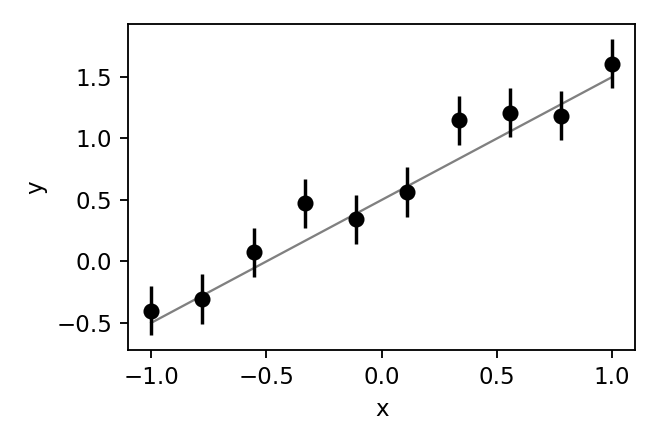

In [3]:
plt.figure(figsize=(4,2.7),dpi=110)
plt.errorbar(x, y_obs, yerr=σ, linestyle='', fmt='o', c='k')
plt.plot(x, y_true, c='grey', lw=1, zorder=0)
plt.ylabel('y')
plt.xlabel('x')
plt.tight_layout()
plt.show()

In [4]:
with pm.Model() as model:
    
    # priors
    m = pm.Uniform('m', lower=0., upper=2.)  # m ~ Uniform(0,2)
    b = pm.Uniform('b', lower=0., upper=1.)  # b ~ Uniform(0,1)

    y_true = pm.Deterministic('y_true', m*x+b)
    
    # log_likelihood
    logl = pm.Normal('logl', mu=y_true, sigma=σ, observed=y_obs)

AttributeError: __enter__

In [ ]:
pm.model_to_graphviz(model)

In [ ]:
with model:
    idata = pm.sample()

In [ ]:
az.plot_trace(idata, var_names=['m','b'], figsize=(7,4))
plt.tight_layout()

In [ ]:
fig = corner.corner(idata, var_names=['m','b'], labels=["m", "b"], truths=[m_true, b_true])
fig.set_size_inches(3.5, 3.5)

### Problem 2: The Mass-Radius Relation for Small Exoplanets

The mass-radius relation is a relationship between the radius $R$ of an exoplanet and its mass $M$. We usually call planets smaller than the Neptune size $(R < 4 R_{\oplus})$ small planets. In the Solar System, we don't have any planets between the Earth and Neptune sizes ($ 1-4 R_{\oplus}$), whereas in extrasolar systems, plenty of planets with radii in the range are observed. Thus, it's extremely intriguing to study the compositions of these planets and understand why we don't have one in the Solar System.

In this problem, you will work on one of the most exciting exoplanet advances this year, the mass-radius relation for small exoplanets around M-dwarfs. The paper was just published 11 days ago by [Luque et al., Science 377, 1211 (2022)](https://ui.adsabs.harvard.edu/abs/2022arXiv220903871L/abstract). We will reproduce some of their results using the PyMC.

In [ ]:
## Download the dataset from Luque et al. 2022
data = pd.read_csv("https://carmenes.caha.es/ext/tmp/TMP.csv")
data.head()

In [ ]:
data.columns

In [ ]:
## Extract mass and radius and their uncertainties from the data; both M and R are in Earth unit 
M = data.M_Mterra
R = data.R_Rterra

err_M = (data.edM_Mterra+data.euM_Mterra)/2  # Assume the + and - errors on M and R are symmetric.
err_R = (data.edR_Rterra+data.euR_Rterra)/2

In [ ]:
## Plot the mass and radius of small planets around M-dwarfs
plt.figure(figsize=(5,4),dpi=110)
plt.errorbar(M, R, xerr=err_M, yerr=err_R,
             linestyle='', fmt='o', markersize=4, elinewidth=1.2, capsize=1.2, c='grey')
plt.scatter(M, R, c=data['rho_gcm-3'], zorder=100, cmap='plasma_r')
plt.xscale('log')
plt.xlabel('Mass [Earth mass]')
plt.ylabel('Radius [Earth radius]')
plt.colorbar(label=r'Density [g/cm$^3$]')
plt.tight_layout()
plt.show()

Ponder that for a moment. What do you observe? Do you see any trends in planets' compositions?

Exoplaneteers made up cute names to describe planets in different compositions.
- "Rocky world" if a planet has a bulk density similar to the Earth.
- "Water world" if a planet has a bulk density consistent with 50% rocky and 50% water ice.
- "Puff planet" if a planet has a bulk density smaller than the "Water World" density.

#### Problem 2(a) The Mass-Radius Relation for Rocky planets

Let's first focus on the rocky worlds and model their mass-radius relation.

In [ ]:
## Build a mask to select planets with the Earth density or higher
rho = data['rho_gcm-3']
rho_earth = 4*np.pi/3  # in M_earth/R_earth^3 unit
mask = rho > rho_earth

In [ ]:
## Select planets with the Earth density or higher
rocky_R = R[mask].values
rocky_err_R = err_R[mask].values

rocky_M = M[mask].values
rocky_err_M = err_M[mask].values

rocky_rho = rho[mask].values  # for plotting purpose only

In [ ]:
## Plot the masses and radii for rocky worlds
plt.figure(figsize=(5,4),dpi=110)
plt.errorbar(rocky_M, rocky_R, xerr=rocky_err_M, yerr=rocky_err_R, 
             linestyle='', fmt='o', markersize=4, elinewidth=1.2, capsize=1.2, c='grey')
plt.scatter(rocky_M, rocky_R, c=rocky_rho, zorder=100, cmap='plasma_r')
plt.xscale('log')
plt.xlabel('Mass [Earth mass]')
plt.ylabel('Radius [Earth radius]')
plt.colorbar(label=r'Density [g/cm$^3$]')
plt.tight_layout()
plt.show()

Let's write down the mass-radius relation for rocky worlds as a power law.

$R = aM^b$, where $a$ is proportional to $1/\rho_{\oplus}$, and $b$ is unitless. If the relation follows $M = \frac{4}{3}\pi R^3 \rho$, we have $a = 1$ and $b = 1/3$. However, in reality, the interior density of planets is not uniform and depends on the equation of state.

In [ ]:
## Build a PyMC model to find parameters of interest {a, b}.
with pm.Model() as rocky:
    
    # priors
    
    # log_a ~ Uniform(np.log(0.1),np.log(10))
    loga = # YOUR_CODE_HERE
    
    # log_b ~ Uniform(np.log(0.1),np.log(1))
    logb = # YOUR_CODE_HERE
    
    a = pm.Deterministic('a', # YOUR_CODE_HERE)
    b = pm.Deterministic('b', # YOUR_CODE_HERE)
    
    # priors on masses from observations
    mass = pm.Normal('mass', mu=rocky_M, sigma=rocky_err_M)
    
    R_true = pm.Deterministic('R_true', # YOUR_CODE_HERE)

    # log_likelihood
    logl_R = pm.Normal('logl_R', # YOUR_CODE_HERE)

In [ ]:
pm.model_to_graphviz(rocky)

In [ ]:
with rocky:
    idata = pm.sample()

In [ ]:
az.plot_trace(idata, var_names=['a','b'], figsize=(7,4))
plt.tight_layout()

In [ ]:
## Plot the fitted model
plt.figure(figsize=(5,4),dpi=110)

plt.errorbar(rocky_M, rocky_R, xerr=rocky_err_M, yerr=rocky_err_R, 
             linestyle='', fmt='o', markersize=4, elinewidth=1.2, capsize=1.2, c='grey')
plt.scatter(rocky_M, rocky_R, c=rocky_rho, zorder=100, cmap='plasma_r')

posterior_a = idata.posterior.a.values.ravel()
posterior_b = idata.posterior.b.values.ravel()

# Draw 100 samples from the posterior and plot the relation
x_arr = np.logspace(-0.5,1.5,20)
ndraws = 100
for i in range(ndraws):
    draw = np.random.randint(4000)
    plt.plot(x_arr,np.median(posterior_a[i])*x_arr**np.median(posterior_b[i]),c='grey',alpha=0.1,lw=0.8)

plt.xscale('log')
plt.xlabel('Mass [Earth mass]')
plt.ylabel('Radius [Earth radius]')
plt.colorbar(label=r'Density [g/cm$^3$]')
plt.tight_layout()
plt.show()

#### Problem 2(b) The Mass-Radius Relation for Rocky+Water Worlds (Advanced)

Let's now add water worlds and model the mass-radius relation for both rocky and water worlds. Physically, it will require two models to describe the mass-radius relations for rocky and water worlds. The tricky part is we don't know exactly which kind of worlds a planet is belong to. In this situation, it is helpful to introduce a categorical variable.

In [ ]:
## Build a mask to select rocky and water worlds
rho_water = rho_earth/2
mask = rho > rho_water

In [ ]:
## Select select rocky and water worlds; I'm going to use a terrible name here "nopuffy" to describe them.
nopuffy_R = R[mask].values
nopuffy_err_R = err_R[mask].values

nopuffy_M = M[mask].values
nopuffy_err_M = err_M[mask].values

nopuffy_rho = rho[mask].values  # for plotting purpose only

In [ ]:
## Plot the masses and radii for rocky and water worlds
plt.figure(figsize=(5,4),dpi=110)
plt.errorbar(nopuffy_M, nopuffy_R, xerr=nopuffy_err_M, yerr=nopuffy_err_R, 
             linestyle='', fmt='o', markersize=4, elinewidth=1.2, capsize=1.2, c='grey')
plt.scatter(nopuffy_M, nopuffy_R, c=nopuffy_rho, zorder=100, cmap='plasma_r')
plt.xscale('log')
plt.xlabel('Mass [Earth mass]')
plt.ylabel('Radius [Earth radius]')
plt.colorbar(label=r'Density [g/cm$^3$]')
plt.tight_layout()
plt.show()

In [ ]:
## Build a PyMC model to find parameters of interest {a, b}.
with pm.Model() as nopuffy:
    
    # Two categories for water and rocky worlds
    p = pm.Dirichlet("p", a=np.ones(2), shape=2)
    z = pm.Categorical("z", p=p, shape=len(nopuffy_R))
    
    # priors on log_a, log_b, mass
    # YOUR_CODE_HERE
    
    # Calculate R_true
    # YOUR_CODE_HERE

    # log_likelihood
    # YOUR_CODE_HERE

In [ ]:
pm.model_to_graphviz(nopuffy)

In [ ]:
with nopuffy:
    idata = pm.sample(target_accept=0.9)

In [ ]:
az.plot_trace(idata, var_names=['a','b','p'], figsize=(7,5))
plt.tight_layout()

In [ ]:
az.plot_trace(idata, var_names=['z'], figsize=(7,30), compact=False)
plt.tight_layout()

Ponder that for a moment and make sure everything makes sense.

In [ ]:
## Plot the fitted models
plt.figure(figsize=(5,4),dpi=110)

plt.errorbar(nopuffy_M, nopuffy_R, xerr=nopuffy_err_M, yerr=nopuffy_err_R, 
             linestyle='', fmt='o', markersize=4, elinewidth=1.2, capsize=1.2, c='grey')
plt.scatter(nopuffy_M, nopuffy_R, c=nopuffy_rho, zorder=100, cmap='plasma_r')

posterior_a = idata.posterior.a.values.ravel()
posterior_b = idata.posterior.b.values.ravel()

# Draw 100 samples from the posterior and plot the relation
x_arr = np.logspace(-0.8,1.5,20)
ndraws = 100
for i in range(ndraws):
    draw = np.random.randint(4000)
    plt.plot(x_arr,np.median(posterior_a[i])*x_arr**np.median(posterior_b[i]),c='k',alpha=0.1,lw=0.8)

plt.xscale('log')
plt.xlabel('Mass [Earth mass]')
plt.ylabel('Radius [Earth radius]')
plt.colorbar(label=r'Density [g/cm$^3$]')
plt.tight_layout()
plt.show()

#### Bonus Problem: The Mass-Radius Relation for All

Could you build a three-population model for rocky worlds, water worlds, and puffs? What's your interpretation on the results?